# Part 2: Prepare Files

- Extract clicked records
- group by year
- save to separate files

In [1]:
import os
import gzip
import shutil
import pandas as pd
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

read data directory from config file

In [2]:
with open('config') as f:
    path = f.readline()

### unzip a file from network path and copy to local path

The 237 files are stored in a network folder. For each of the files, the following steps are done
* unpack
* copy to local temporay file
* process in chunks
    - group entries by year
    - store the year's records in folders 2018, 2017,...

In addition, a file "unpacked.csv" is created, in which the total number records is stored, and the number of occurrences of each event.

In [3]:
if os.path.isfile('.\\data\\unpacked.csv'):
    unpacked = pd.read_csv('.\\data\\unpacked.csv')
else:
    unpacked = pd.DataFrame(columns=['filename', 'file nr', 
                                    'total', 'sentToMTA', 'clicked', 'rendered', 
                                    'bounced', 'skipped', 'feedback', 'unsubscribed'])
unpacked = unpacked.set_index('filename')

In [4]:
tmp_file = '.\\data\\tmp.csv'

total = len(os.listdir(path))
for i, filename in enumerate(os.listdir(path)):
    if 0 <= i <= 0:
        print("processing file nr {}".format(i))
        print(path + filename)

        unpacked.loc[filename] = [i,0,0,0,0,0,0,0,0]

        try:
           # unzip to tmp_file
            with gzip.open(os.path.join(path,filename)) as f_in:
                with open(tmp_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                    f_in.close()
                    f_out.close()
        except:
            print('Error unpacking file nr ' + str(i) + ' ', filename)
            continue

        df_clicked = pd.DataFrame()
        reader = pd.read_csv(tmp_file, sep=';', chunksize=50000)   
        for chunk in reader:
            unpacked.loc[filename, 'total'] += len(chunk)
            unpacked.loc[filename, 'clicked'] += chunk['click.Timestamp'].count()
            unpacked.loc[filename, 'rendered'] += chunk['render.Timestamp'].count()
            unpacked.loc[filename, 'bounced'] += chunk['bounce.Timestamp'].count()
            unpacked.loc[filename, 'skipped'] += chunk['skip.Timestamp'].count()
            unpacked.loc[filename, 'sentToMTA'] += chunk['sentToMTA.Timestamp'].count()
            unpacked.loc[filename, 'feedback'] += chunk['feedback.Timestamp'].count()
            unpacked.loc[filename, 'unsubscribed'] += chunk['unsubscribe.Timestamp'].count()
            

            chunk['Year'] = chunk['record.Timestamp'].str[:4]
            for year in chunk['Year'].unique():
                df = chunk[chunk['Year']==year] 
                df = df.dropna(subset=['click.Timestamp'])  
                df_clicked = pd.concat([df_clicked, df]) 
       
        unpacked.to_csv('.\\data\\unpacked.csv')
        df_clicked.to_csv('.\\data\\' + year + '\\' + filename + '_clicked.csv')


processing file nr 0
//dsw140/CGB-Mapp-Data/newsletterSAS-Full-Raw-Data-Export-SCO-2015-generic-28060-2019_08_13_16_39_17.100.csv.gz


## Append all clicked records from 2018 into one single csv file

In [5]:
for i, filename in enumerate(os.listdir('.\\data\\2018')):
    df = pd.read_csv(os.path.join('.\\data\\2018',filename))
    if i==0:
        df.to_csv('.\\data\\2018_clickd.csv')
    else:
        df.to_csv('.\\data\\2018_clickd.csv', mode='a', header=False)

In [6]:
print('File size in MB:')
os.path.getsize('.\\data\\2018_clickd.csv') / 1024 / 1024

File size in MB:


1635.6798753738403

## Display summary of processed files

In [7]:
df_summary = pd.read_csv('.\\data\\unpacked.csv')
df_summary.head()

,filename,file nr,total,sentToMTA,clicked,rendered,bounced,skipped,feedback,unsubscribed
0,SAS-Full-Raw-Data-Export-SCO-2015-generic-2806...,0,1829054,1341036,39263,214844,12355,221190,237,129
1,SAS-Full-Raw-Data-Export-SCO-2015-generic-2806...,1,2456990,1046881,21254,154481,15336,1218648,367,23
2,SAS-Full-Raw-Data-Export-SCO-2015-generic-2806...,2,1817534,1353743,41845,224277,11084,186074,318,193
3,SAS-Full-Raw-Data-Export-SCO-2015-generic-2806...,3,1824369,1361447,44995,229312,12298,175946,260,108
4,SAS-Full-Raw-Data-Export-SCO-2015-generic-2806...,4,1824063,1353994,52037,232250,13012,172213,455,101


In [8]:
df3 = df_summary.sum()
df3
df3[3:].plot(kind='bar')

### Display proportion of clicked and rendered emails in total emails sent

In [9]:

df3 = df3.drop('filename')
diff = df3['total'] - df3
df3 = pd.DataFrame([diff, df3])
df3

,file nr,total,sentToMTA,clicked,rendered,bounced,skipped,feedback,unsubscribed
0,437954763,0,140125045,428344550,387272212,434721777,361583504,437905970,437941192
1,27495,437982258,297857213,9637708,50710046,3260481,76398754,76288,41066


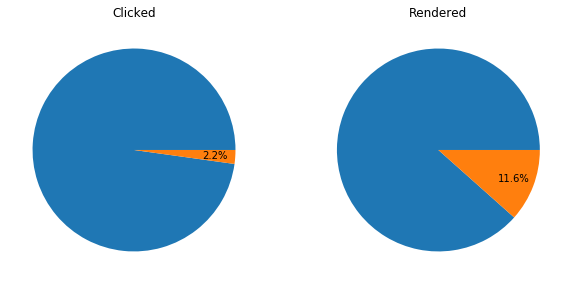

In [10]:
def my_autopct(pct):
    if pct < 80:
        return ('%.1f' % pct)+'%'
    else:
        return ''

ax_list = df3[['clicked', 'rendered']].plot.pie(subplots=True, autopct=my_autopct, pctdistance = 0.8, legend=False, figsize=(10,10), labels=None);
for ax in ax_list:
    ax.set_ylabel('')

ax_list[0].title.set_text('Clicked')
ax_list[1].title.set_text('Rendered')

### Try the same without `bounced` and `skipped` records

Emails that get bounced or skipped never show up in the recipient's inbox, and thus can never be opened or clicked. We subtract the number of skipped and bounced records from the total number of records to display the share of clicked and rendered emails in all emails that arrived in the recipients inbox.

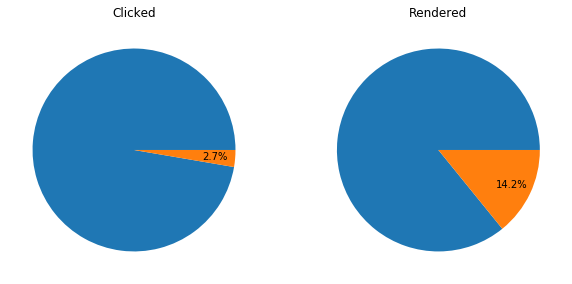

In [11]:
df3 = df_summary.sum()
df3 = df3.drop('filename')
df3['total'] = df3['total'] - df3['bounced'] - df3['skipped']

diff = df3['total'] - df3
df3 = pd.DataFrame([diff, df3])

ax_list = df3[['clicked', 'rendered']].plot.pie(subplots=True, autopct=my_autopct, pctdistance = 0.8, legend=False, figsize=(10,10), labels=None);
for ax in ax_list:
    ax.set_ylabel('')

ax_list[0].title.set_text('Clicked')
ax_list[1].title.set_text('Rendered')